In [1]:
# === (A placer AVANT le bloc KMeans compare) ===============================
import os, sqlite3, pandas as pd

def build_feat_from_sqlite(db_path="olist.db"):
    orders_t, items_t, reviews_t = "orders", "order_items", "order_reviews"
    order_id_col, customer_id_col = "order_id", "customer_id"
    
    order_status_col  = "order_status"
    purchase_ts_col   = "order_purchase_timestamp"

    delivered_date_col = "order_delivered_customer_date"
    eta_date_col       = "order_estimated_delivery_date"
    price_col          = "price"
    review_score_col   = "review_score"

    with sqlite3.connect(db_path) as conn:
        ref_date = pd.read_sql_query(
            f"SELECT MAX({purchase_ts_col}) AS max_date FROM {orders_t};", conn
        )["max_date"].iloc[0]

        sql = f"""
        WITH base AS (
          SELECT 
            o.{customer_id_col} AS customer_id,
            o.{order_id_col}    AS order_id,
            DATE(o.{purchase_ts_col}) AS purchase_date,
            SUM(oi.{price_col}) AS order_revenue,
            CAST(julianday(o.{delivered_date_col}) - julianday(o.{eta_date_col}) AS INT) AS delay_days
          FROM {orders_t} o
          JOIN {items_t}  oi ON oi.{order_id_col} = o.{order_id_col}
          WHERE o.{order_status_col} = 'delivered'
          GROUP BY o.{customer_id_col}, o.{order_id_col}
        ),
        by_client AS (
          SELECT
            customer_id,
            MIN(purchase_date) AS first_order_date,
            MAX(purchase_date) AS last_order_date,
            COUNT(DISTINCT order_id) AS frequency,
            ROUND(SUM(order_revenue), 2) AS monetary,
            ROUND(AVG(CASE WHEN delay_days>=3 THEN 1.0 ELSE 0.0 END), 3) AS delay_rate_ge3d
          FROM base
          GROUP BY customer_id
        ),
        reviews AS (
          SELECT o.{customer_id_col} AS customer_id,
                 ROUND(AVG(r.{review_score_col}), 3) AS avg_review_score
          FROM {reviews_t} r
          JOIN {orders_t}  o ON o.{order_id_col} = r.{order_id_col}
          WHERE o.{order_status_col} = 'delivered'
          GROUP BY o.{customer_id_col}
        )
        SELECT 
          b.customer_id,
          CAST(julianday('{ref_date}') - julianday(b.last_order_date) AS INT) AS recency_days,
          b.frequency,
          b.monetary,
          ROUND(CASE WHEN b.frequency>0 THEN b.monetary*1.0/b.frequency ELSE NULL END, 2) AS aov,
          COALESCE(r.avg_review_score, 0.0) AS avg_review_score,
          COALESCE(b.delay_rate_ge3d, 0.0)  AS delay_rate_ge3d,
          b.last_order_date
        FROM by_client b
        LEFT JOIN reviews r USING(customer_id);
        """
        feat_local = pd.read_sql_query(sql, conn)

    # Nettoyage minimal
    feat_local = feat_local.fillna({'avg_review_score':0.0, 'delay_rate_ge3d':0.0})
    feat_local = feat_local[feat_local['frequency']>0].reset_index(drop=True)
    return feat_local

# --- 1) Si un CSV existe déjà (export de ton notebook principal), on le charge
if os.path.exists("feat.csv"):
    feat = pd.read_csv("feat.csv")
else:
    # --- 2) Sinon, on le (re)construit depuis SQLite
    feat = build_feat_from_sqlite("olist.db")

# Vérif des colonnes attendues
needed = ['customer_id','recency_days','frequency','monetary','aov','avg_review_score','delay_rate_ge3d']
missing = [c for c in needed if c not in feat.columns]
print("Colonnes manquantes:", missing if missing else "Aucune — prêt à lancer KMeans.")

Colonnes manquantes: Aucune — prêt à lancer KMeans.



=== Variante: RFM — features: ['recency_days', 'frequency', 'monetary'] ===


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


Saved -> outputs/kmeans_compare/RFM/bars_RFM_K3.png


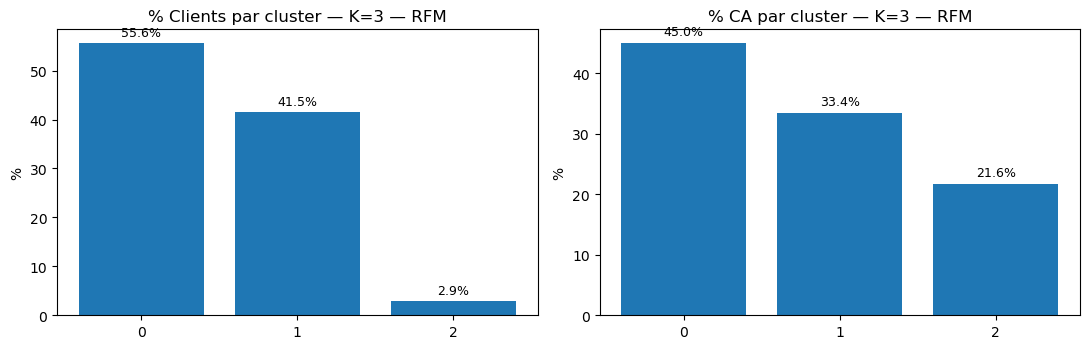

Saved -> outputs/kmeans_compare/RFM/radar_RFM_K3.png


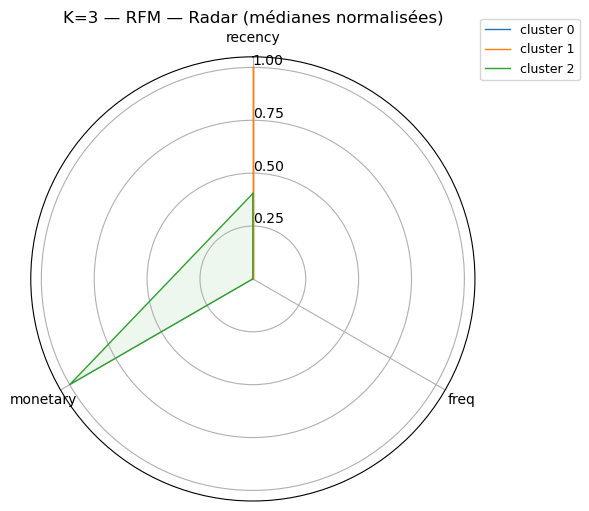

Saved -> outputs/kmeans_compare/RFM/bars_RFM_K4.png


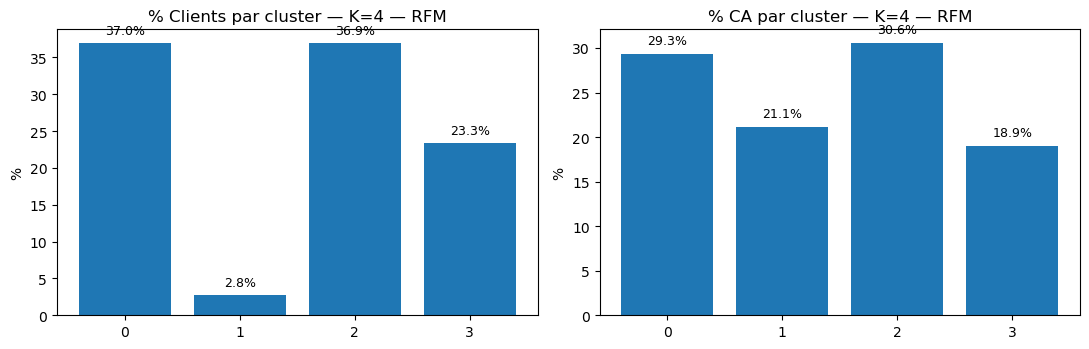

Saved -> outputs/kmeans_compare/RFM/radar_RFM_K4.png


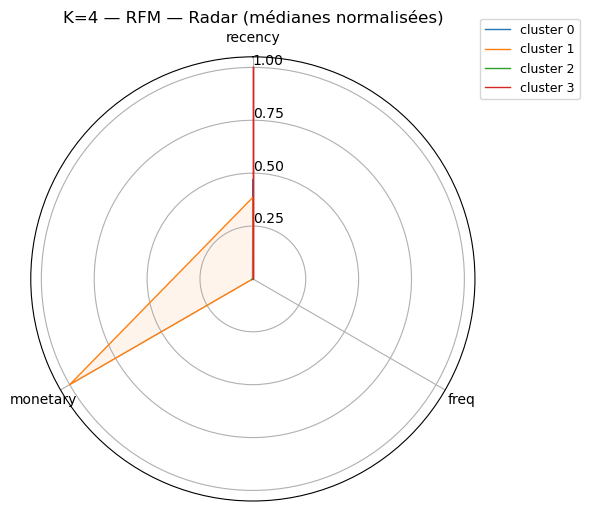

Saved -> outputs/kmeans_compare/RFM/bars_RFM_K5.png


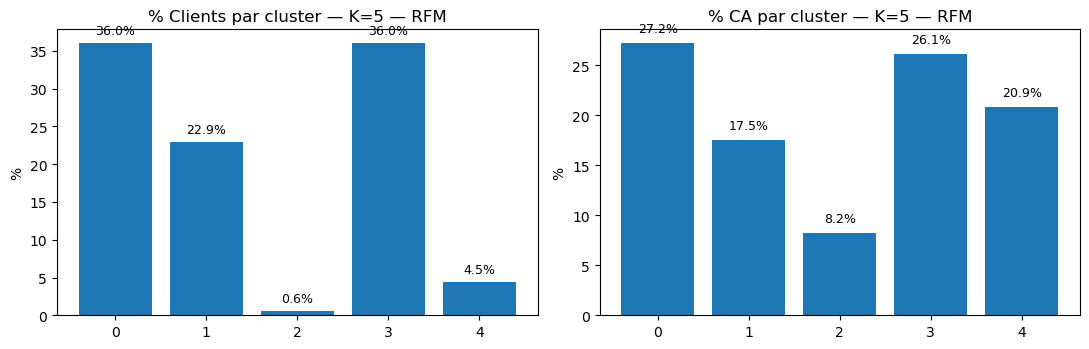

Saved -> outputs/kmeans_compare/RFM/radar_RFM_K5.png


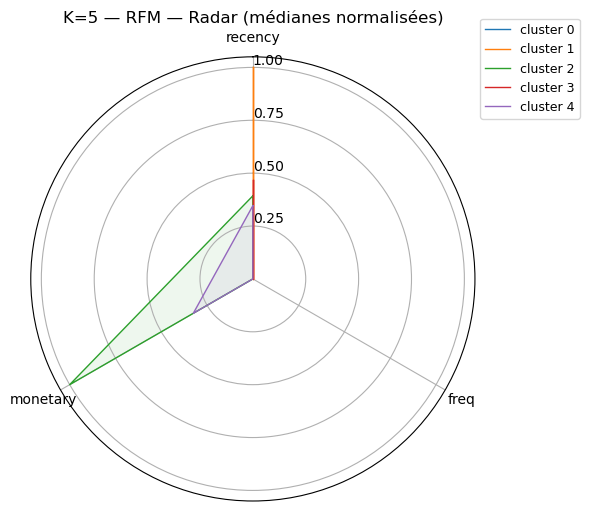


=== Variante: RFM+review — features: ['recency_days', 'frequency', 'monetary', 'avg_review_score'] ===
Saved -> outputs/kmeans_compare/RFM_review/bars_RFM+review_K3.png


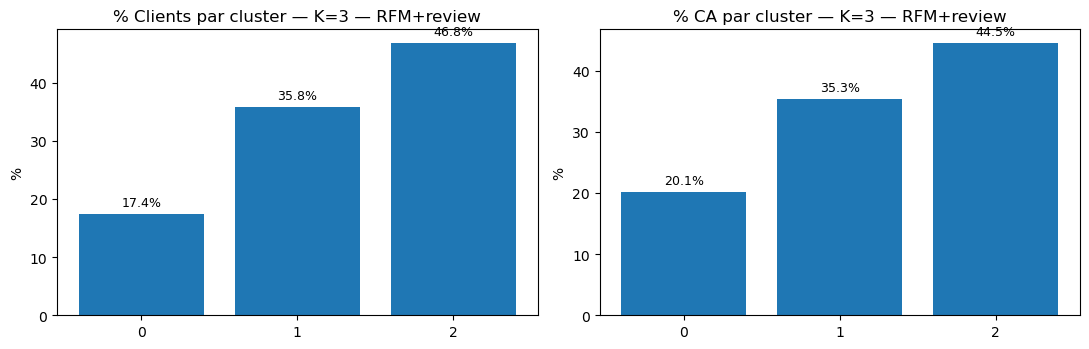

Saved -> outputs/kmeans_compare/RFM_review/radar_RFM+review_K3.png


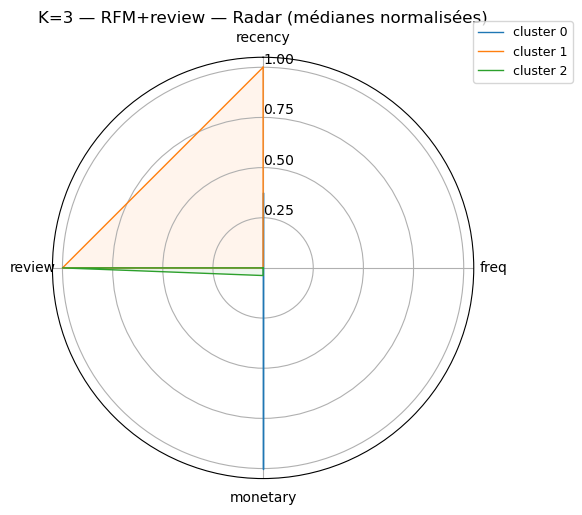

Saved -> outputs/kmeans_compare/RFM_review/bars_RFM+review_K4.png


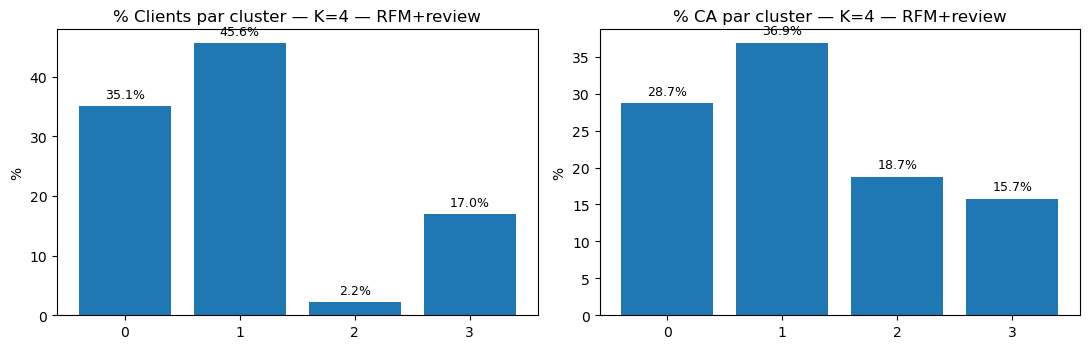

Saved -> outputs/kmeans_compare/RFM_review/radar_RFM+review_K4.png


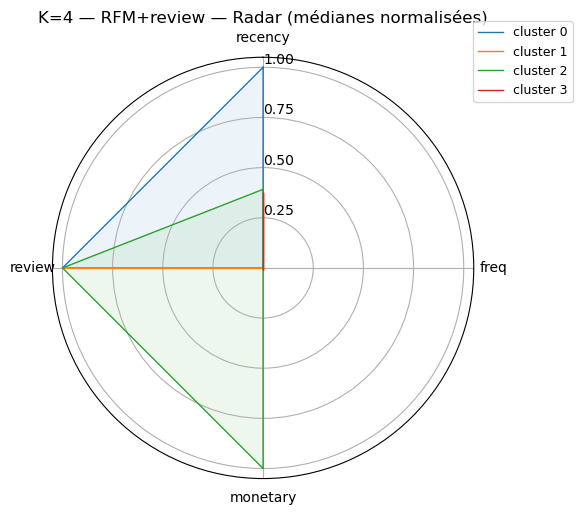

Saved -> outputs/kmeans_compare/RFM_review/bars_RFM+review_K5.png


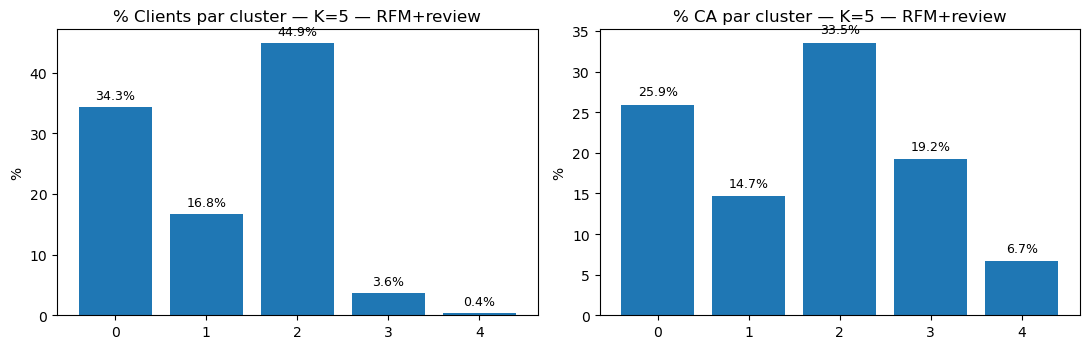

Saved -> outputs/kmeans_compare/RFM_review/radar_RFM+review_K5.png


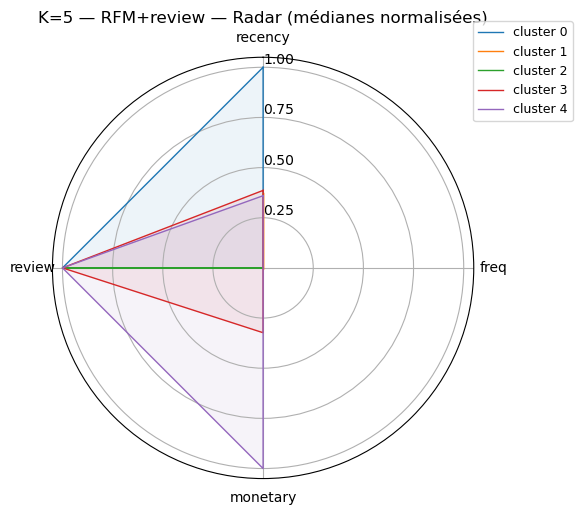


=== Variante: RFM+review+delay+AOV — features: ['recency_days', 'frequency', 'monetary', 'avg_review_score', 'delay_rate_ge3d', 'aov'] ===
Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/bars_RFM+review+delay+AOV_K3.png


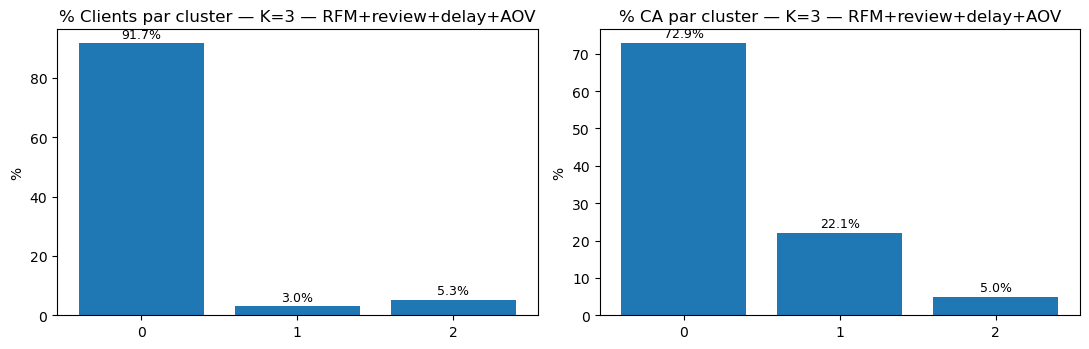

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/radar_RFM+review+delay+AOV_K3.png


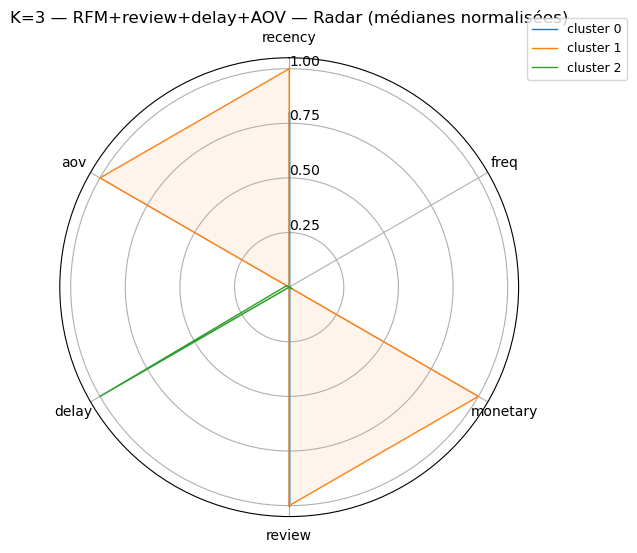

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/bars_RFM+review+delay+AOV_K4.png


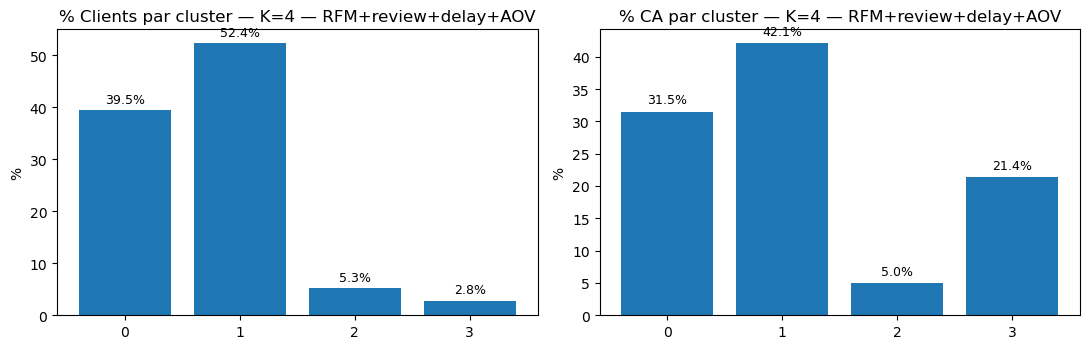

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/radar_RFM+review+delay+AOV_K4.png


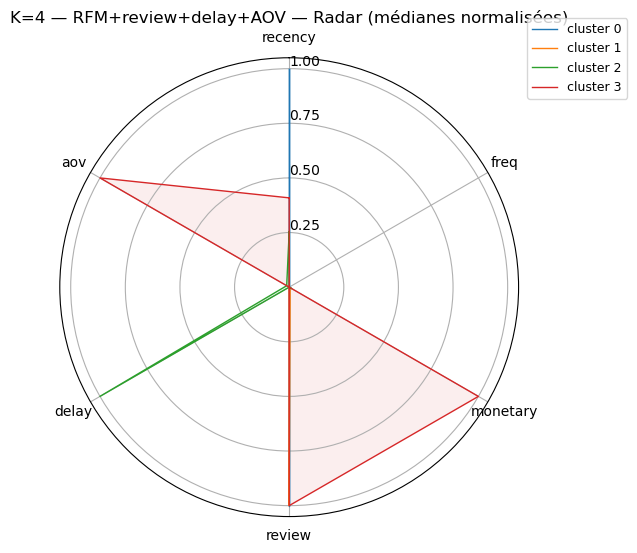

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/bars_RFM+review+delay+AOV_K5.png


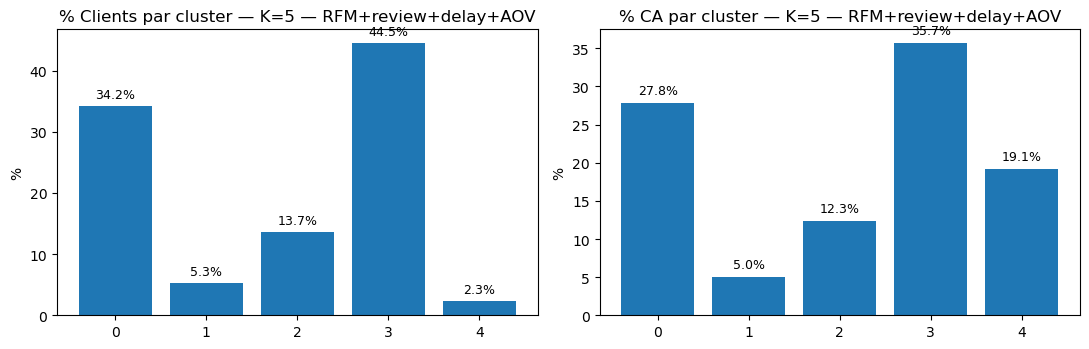

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/radar_RFM+review+delay+AOV_K5.png


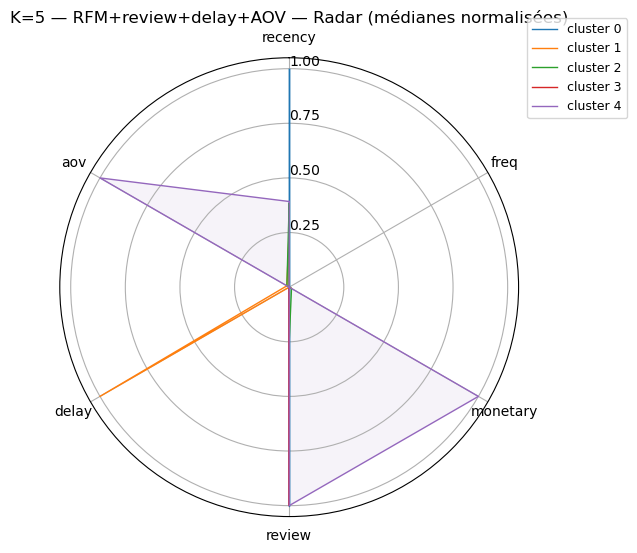

In [2]:
# =========================
# KMeans — comparaison K={3,4,5} et 3 variantes de features
# =========================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --------- 0) Vérifs & dossiers
REQ = ['customer_id','recency_days','frequency','monetary','aov','avg_review_score','delay_rate_ge3d']
missing = [c for c in REQ if c not in feat.columns]
assert not missing, f"Colonnes manquantes dans feat: {missing}"

OUTDIR = "outputs/kmeans_compare"
os.makedirs(OUTDIR, exist_ok=True)

# --------- 1) Définition des variantes
VARIANTS = {
    "RFM":                  ['recency_days','frequency','monetary'],
    "RFM+review":           ['recency_days','frequency','monetary','avg_review_score'],
    "RFM+review+delay+AOV": ['recency_days','frequency','monetary','avg_review_score','delay_rate_ge3d','aov'],
}

# --------- 2) Fonctions utilitaires
def kmeans_labels(X, k, random_state=42):
    km = KMeans(n_clusters=k, n_init=20, algorithm="elkan", random_state=random_state)
    return km.fit_predict(X)

def profile_by_cluster(df, labels):
    """Résumé métier + parts % clients & CA."""
    prof = (df.assign(cluster=labels)
              .groupby('cluster', as_index=False)
              .agg(n_clients=('customer_id','count'),
                   recency_med=('recency_days','median'),
                   freq_med=('frequency','median'),
                   monetary_med=('monetary','median'),
                   aov_med=('aov','median'),
                   review_med=('avg_review_score','median'),
                   delay_med=('delay_rate_ge3d','median'),
                   monetary_sum=('monetary','sum')))
    tot_c = prof['n_clients'].sum()
    tot_r = prof['monetary_sum'].sum()
    prof['clients_share_%']  = 100*prof['n_clients']/tot_c
    prof['revenue_share_%']  = 100*prof['monetary_sum']/tot_r
    return prof.sort_values('cluster').reset_index(drop=True)

def plot_bars(prof, title, savepath=None):
    """% clients & % CA par cluster (2 sous-graphiques)."""
    fig, ax = plt.subplots(1,2, figsize=(11,3.6), sharey=False)
    x = prof['cluster'].astype(str).values
    ax[0].bar(x, prof['clients_share_%'].values)
    ax[0].set_title("% Clients par cluster — " + title)
    ax[0].set_ylabel("%")
    for i,v in enumerate(prof['clients_share_%'].values):
        ax[0].text(i, v+0.8, f"{v:.1f}%", ha='center', va='bottom', fontsize=9)

    ax[1].bar(x, prof['revenue_share_%'].values)
    ax[1].set_title("% CA par cluster — " + title)
    ax[1].set_ylabel("%")
    for i,v in enumerate(prof['revenue_share_%'].values):
        ax[1].text(i, v+0.8, f"{v:.1f}%", ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150)
        print("Saved ->", savepath)
    plt.show()

MED_MAP = {
    "recency_days":    "recency_med",
    "frequency":       "freq_med",
    "monetary":        "monetary_med",
    "aov":             "aov_med",
    "avg_review_score":"review_med",
    "delay_rate_ge3d": "delay_med",
}

def plot_radar(prof, features, title, savepath=None):
    """Radar des médianes normalisées (min–max) pour les variables 'features'."""
    # 1) map features -> median column names in prof
    used_med_cols = [MED_MAP[f] for f in features if MED_MAP[f] in prof.columns]
    if not used_med_cols:
        print("Aucune variable à tracer pour le radar."); 
        return

    # 2) min–max normalization per variable (protect zero-range)
    data  = prof[used_med_cols].copy().astype(float)
    mins  = data.min(axis=0)
    maxs  = data.max(axis=0)
    denom = (maxs - mins).mask(lambda s: s == 0, 1e-9)
    norm  = (data - mins) / denom

    labels = [c.replace('_med','') for c in used_med_cols]
    N = len(labels)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi/2); ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
    ax.set_rlabel_position(0)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(["0.25","0.50","0.75","1.00"])

    # plot each cluster line
    for i, row in norm.iterrows():
        vals = row.values.tolist() + [row.values.tolist()[0]]
        ax.plot(angles, vals, linewidth=1, label=f"cluster {int(prof.loc[i,'cluster'])}")
        ax.fill(angles, vals, alpha=0.08)

    ax.set_title(f"{title} — Radar (médianes normalisées)")
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1), fontsize=9)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150)
        print(f"Saved -> {savepath}")
    plt.show()

# --------- 3) Boucle principale : variantes × K
K_LIST = [3,4,5]

for vname, cols in VARIANTS.items():
    print(f"\n=== Variante: {vname} — features: {cols} ===")
    subdir = os.path.join(OUTDIR, vname.replace('+','_'))
    os.makedirs(subdir, exist_ok=True)

    # Standardisation sur la sous-matrice de features de la variante
    X = feat[cols].values
    Xs = StandardScaler().fit_transform(X)

    for k in K_LIST:
        labels = kmeans_labels(Xs, k=k, random_state=42)
        prof = profile_by_cluster(feat[['customer_id','recency_days','frequency','monetary','aov','avg_review_score','delay_rate_ge3d']].copy(),
                                  labels)

        # Figures
        title = f"K={k} — {vname}"
        f_bars = os.path.join(subdir, f"bars_{vname}_K{k}.png")
        f_radar = os.path.join(subdir, f"radar_{vname}_K{k}.png")
        plot_bars(prof, title, savepath=f_bars)
        plot_radar(prof, cols, title, savepath=f_radar)

        # (option) export CSV du profil
        prof.to_csv(os.path.join(subdir, f"profile_{vname}_K{k}.csv"), index=False)


=== Variante: RFM — features: ['recency_days', 'frequency', 'monetary'] ===
Saved -> outputs/kmeans_compare/RFM/bars_RFM_K3.png


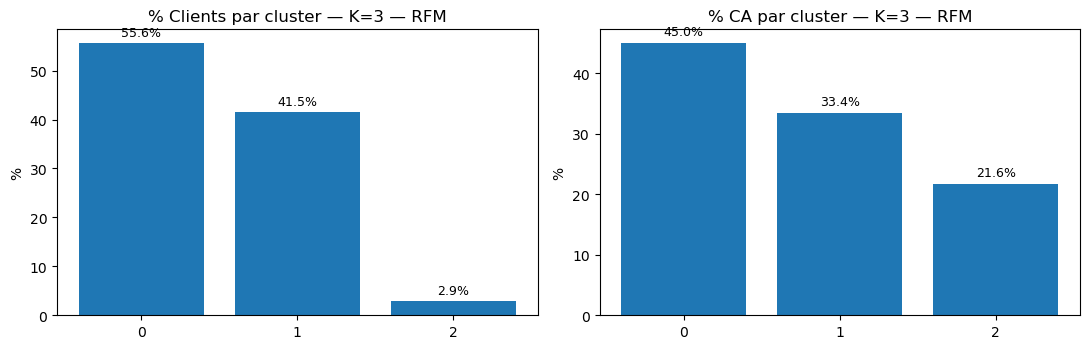

Saved -> outputs/kmeans_compare/RFM/radar_RFM_K3.png


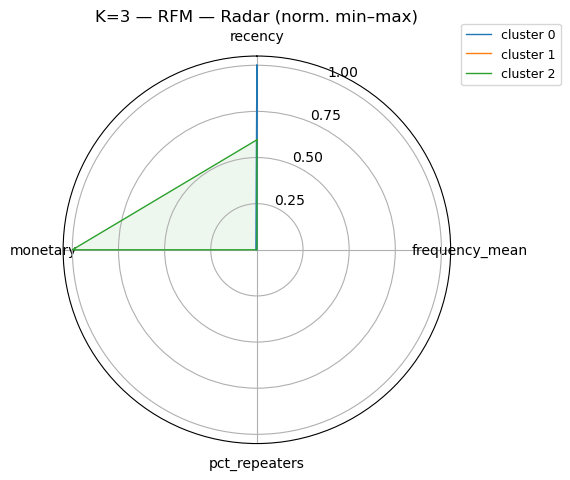

Saved -> outputs/kmeans_compare/RFM/bars_RFM_K4.png


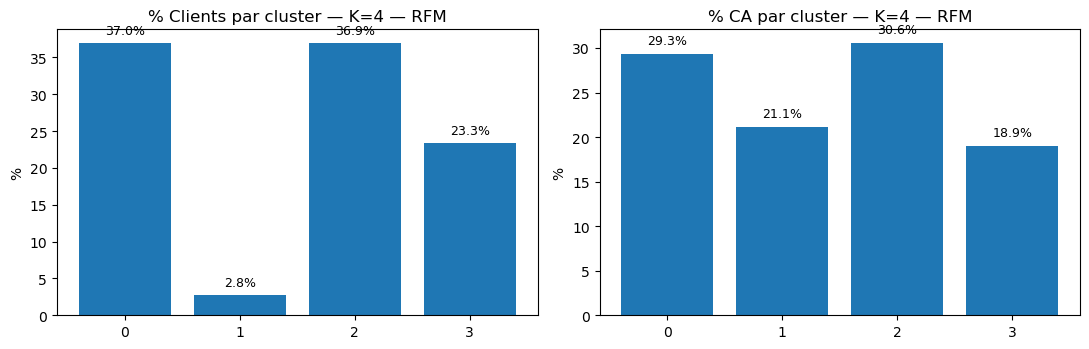

Saved -> outputs/kmeans_compare/RFM/radar_RFM_K4.png


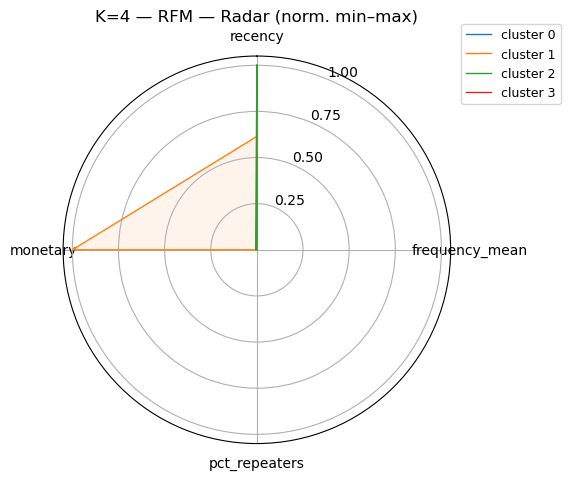

Saved -> outputs/kmeans_compare/RFM/bars_RFM_K5.png


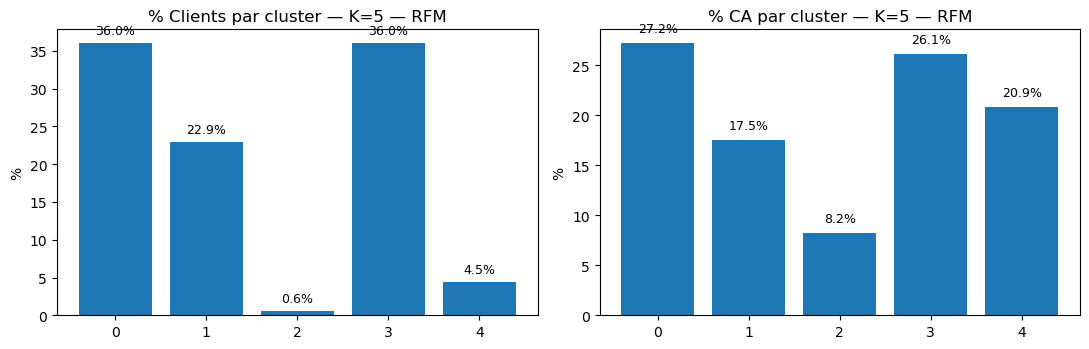

Saved -> outputs/kmeans_compare/RFM/radar_RFM_K5.png


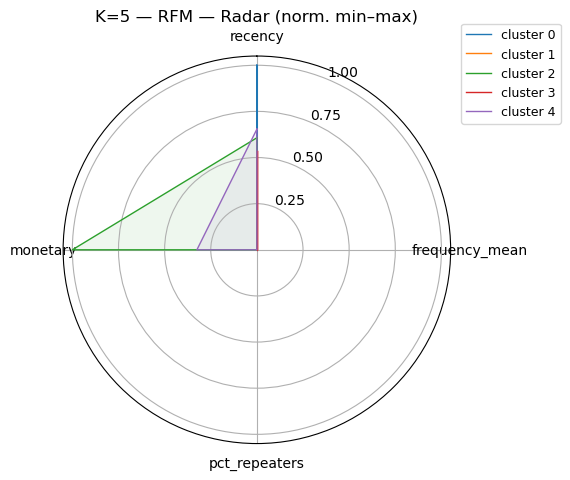


=== Variante: RFM+review — features: ['recency_days', 'frequency', 'monetary', 'avg_review_score'] ===
Saved -> outputs/kmeans_compare/RFM_review/bars_RFM+review_K3.png


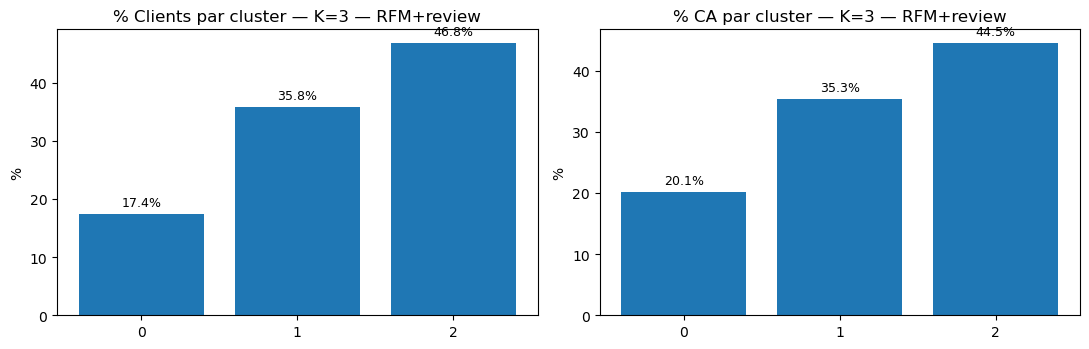

Saved -> outputs/kmeans_compare/RFM_review/radar_RFM+review_K3.png


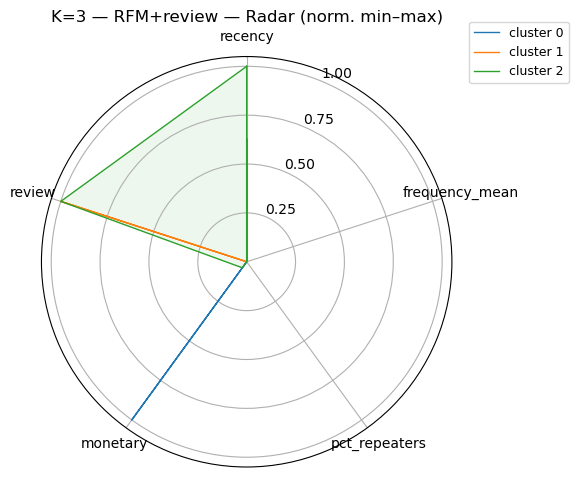

Saved -> outputs/kmeans_compare/RFM_review/bars_RFM+review_K4.png


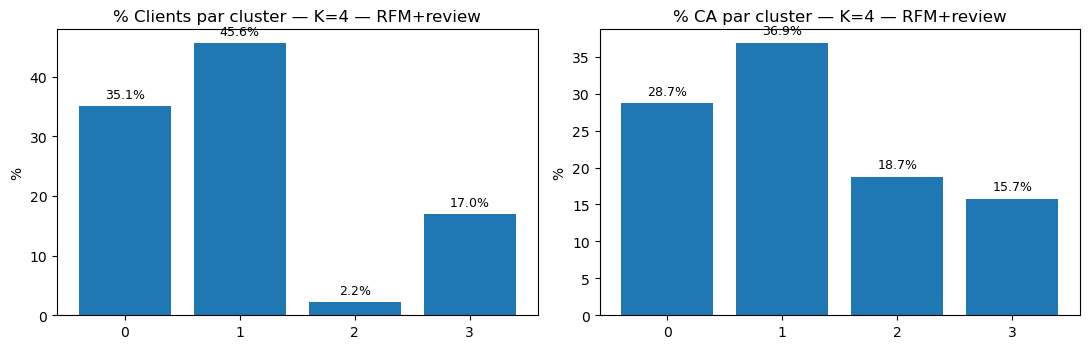

Saved -> outputs/kmeans_compare/RFM_review/radar_RFM+review_K4.png


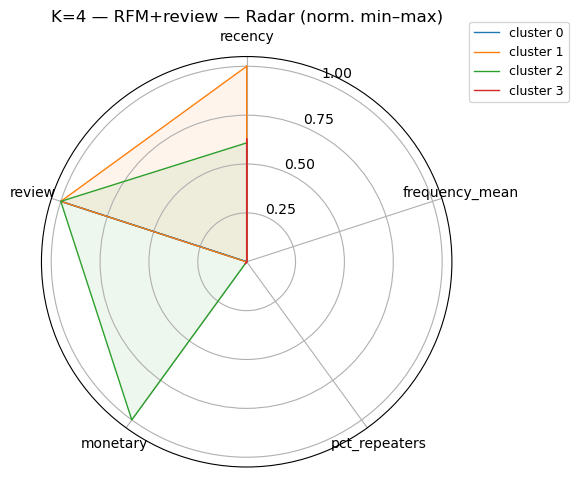

Saved -> outputs/kmeans_compare/RFM_review/bars_RFM+review_K5.png


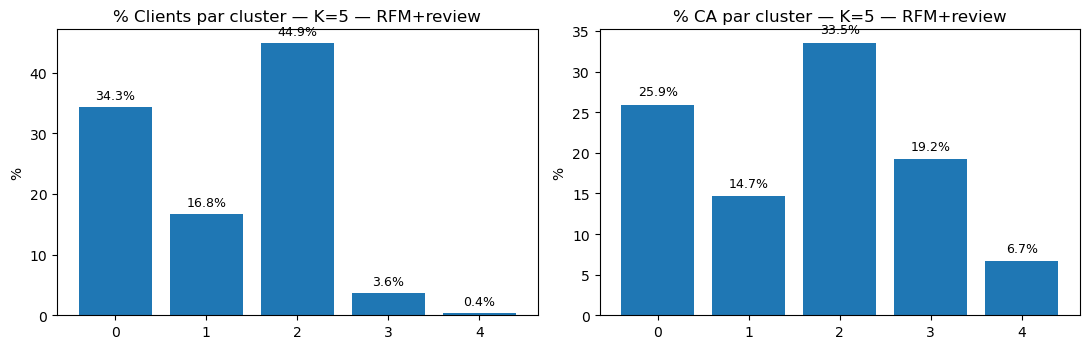

Saved -> outputs/kmeans_compare/RFM_review/radar_RFM+review_K5.png


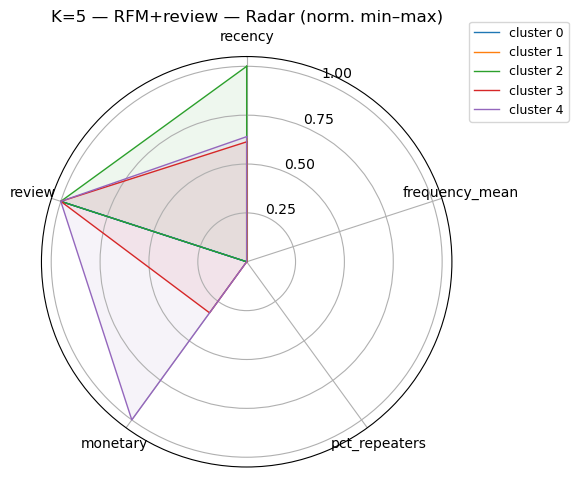


=== Variante: RFM+review+delay+AOV — features: ['recency_days', 'frequency', 'monetary', 'avg_review_score', 'delay_rate_ge3d', 'aov'] ===
Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/bars_RFM+review+delay+AOV_K3.png


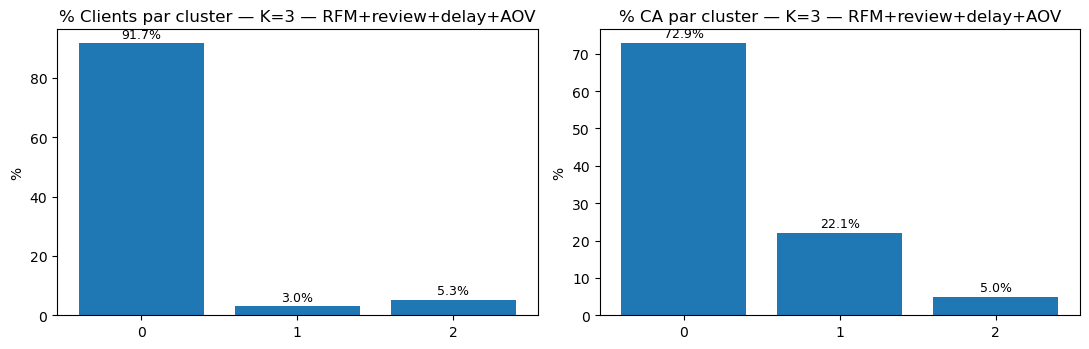

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/radar_RFM+review+delay+AOV_K3.png


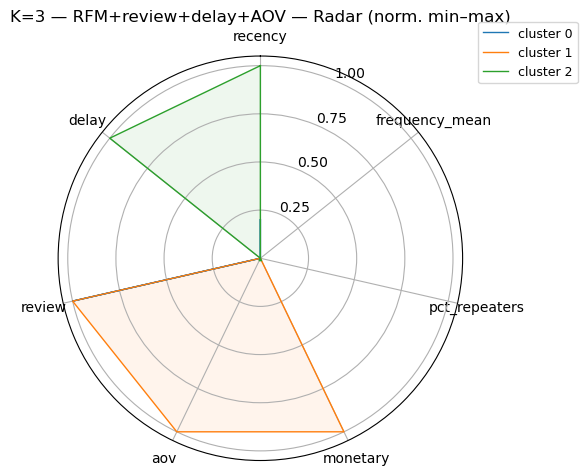

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/bars_RFM+review+delay+AOV_K4.png


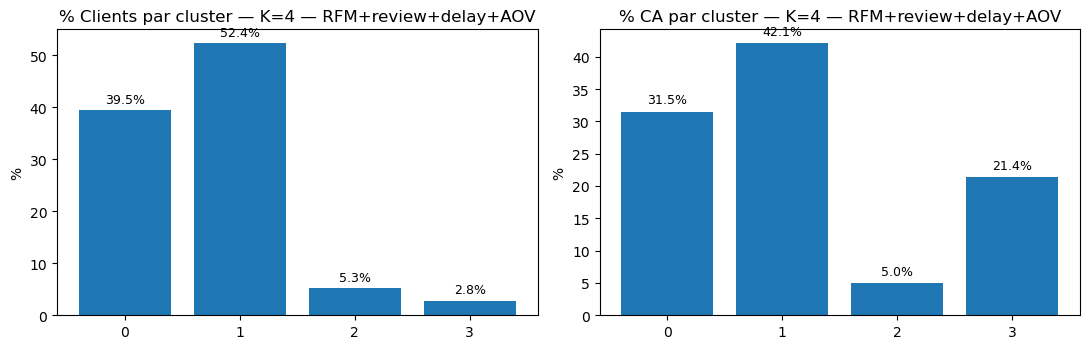

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/radar_RFM+review+delay+AOV_K4.png


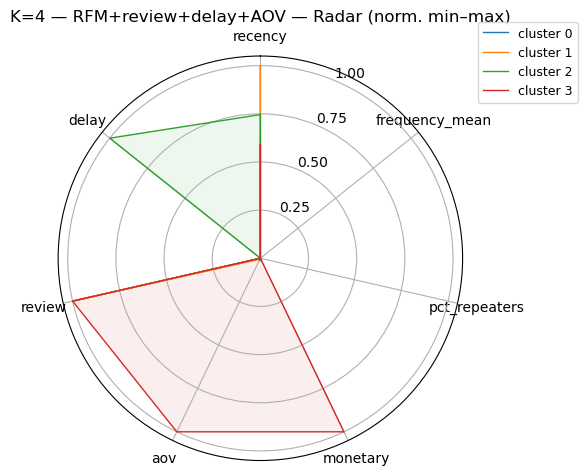

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/bars_RFM+review+delay+AOV_K5.png


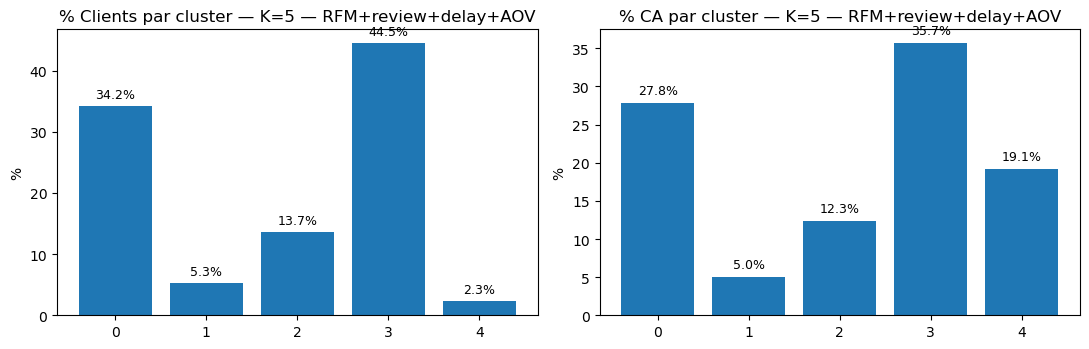

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/radar_RFM+review+delay+AOV_K5.png


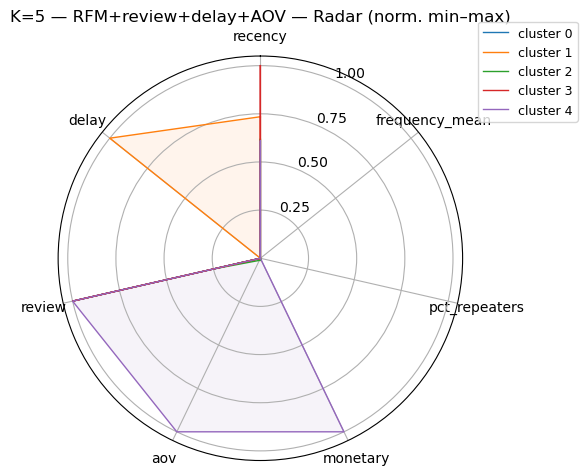

In [3]:
# =========================
# KMeans — comparaison K={3,4,5} et 3 variantes de features
# =========================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --------- 0) Vérifs & dossiers
REQ = ['customer_id','recency_days','frequency','monetary','aov','avg_review_score','delay_rate_ge3d']
missing = [c for c in REQ if c not in feat.columns]
assert not missing, f"Colonnes manquantes dans feat: {missing}"

OUTDIR = "outputs/kmeans_compare"
os.makedirs(OUTDIR, exist_ok=True)

# --------- 1) Définition des variantes
VARIANTS = {
    "RFM":                  ['recency_days','frequency','monetary'],
    "RFM+review":           ['recency_days','frequency','monetary','avg_review_score'],
    "RFM+review+delay+AOV": ['recency_days','frequency','monetary','avg_review_score','delay_rate_ge3d','aov'],
}

# --------- 2) Fonctions utilitaires
def kmeans_labels(X, k, random_state=42):
    km = KMeans(n_clusters=k, n_init=20, algorithm="elkan", random_state=random_state)
    return km.fit_predict(X)

# --------- Profil enrichi : moyennes + % repeaters
def profile_by_cluster_enriched(df, labels):
    # ajoute l'étiquette
    tmp = df.copy()
    tmp["cluster"] = labels

    # agrégats principaux
    g = tmp.groupby("cluster", as_index=False)
    prof = g.agg(
        n_clients    = ("customer_id","count"),
        recency_med  = ("recency_days","median"),
        freq_med     = ("frequency","median"),
        freq_mean    = ("frequency","mean"),
        monetary_med = ("monetary","median"),
        aov_med      = ("aov","median"),
        review_med   = ("avg_review_score","median"),
        delay_med    = ("delay_rate_ge3d","median"),
        monetary_sum = ("monetary","sum"),
    )

    # % repeaters (frequency >= 2) – sans apply/reset_index(name=…)
    tmp["is_repeater"] = (tmp["frequency"] >= 2).astype(float)
    rep = tmp.groupby("cluster", as_index=False)["is_repeater"].mean() \
             .rename(columns={"is_repeater": "pct_repeaters"})
    prof = prof.merge(rep, on="cluster", how="left")

    # parts %
    tot_c = prof["n_clients"].sum() or 1
    tot_r = prof["monetary_sum"].sum() or 1
    prof["clients_share_%"] = 100 * prof["n_clients"] / tot_c
    prof["revenue_share_%"] = 100 * prof["monetary_sum"] / tot_r

    return prof.sort_values("cluster").reset_index(drop=True)

# --------- Radar reparamétré
def plot_radar_enriched(prof, vars_for_radar, title, savepath=None):
    import numpy as np, matplotlib.pyplot as plt

    # mapping "nom simple" -> colonne source (avec inversion de recency)
    cols = {}
    for v in vars_for_radar:
        if v == 'recency':            cols[v] = -prof['recency_med']  # plus récent => plus grand
        elif v == 'frequency_mean':   cols[v] = prof['freq_mean']
        elif v == 'pct_repeaters':    cols[v] = prof['pct_repeaters']
        elif v == 'frequency_med':    cols[v] = prof['freq_med']
        elif v == 'monetary':         cols[v] = prof['monetary_med']
        elif v == 'aov':              cols[v] = prof['aov_med']
        elif v == 'review':           cols[v] = prof['review_med']
        elif v == 'delay':            cols[v] = prof['delay_med']
        else: raise ValueError(f"Var inconnue pour radar: {v}")

    data = pd.DataFrame(cols)

    # min–max colonne par colonne (protège divisions nulles)
    mins, maxs = data.min(0), data.max(0)
    denom = (maxs - mins).replace(0, 1e-9)
    norm = (data - mins) / denom

    labels = list(norm.columns)
    N = len(labels)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi/2); ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
    ax.set_yticks([0.25,0.5,0.75,1.0]); ax.set_yticklabels(["0.25","0.50","0.75","1.00"])

    for i,row in norm.iterrows():
        vals = row.tolist(); vals += vals[:1]
        ax.plot(angles, vals, linewidth=1, label=f"cluster {int(prof.loc[i,'cluster'])}")
        ax.fill(angles, vals, alpha=0.08)

    ax.set_title(f"{title} — Radar (norm. min–max)")
    ax.legend(loc='upper right', bbox_to_anchor=(1.3,1.1), fontsize=9)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=150); print("Saved ->", savepath)
    plt.show()

# --------- 3) Boucle principale : variantes × K
VARS_FOR_RADAR = {
    "RFM":                  ['recency','frequency_mean','pct_repeaters','monetary'],
    "RFM+review":           ['recency','frequency_mean','pct_repeaters','monetary','review'],
    "RFM+review+delay+AOV": ['recency','frequency_mean','pct_repeaters','monetary','aov','review','delay'],
}

for vname, cols in VARIANTS.items():
    print(f"\n=== Variante: {vname} — features: {cols} ===")
    subdir = os.path.join(OUTDIR, vname.replace('+','_'))
    os.makedirs(subdir, exist_ok=True)

    # fit KMeans comme avant
    Xs = StandardScaler().fit_transform(feat[cols].values)

    for k in [3,4,5]:
        labels = kmeans_labels(Xs, k=k, random_state=42)

        # ⬇️ NOUVELLE fonction de profil
        prof = profile_by_cluster_enriched(feat, labels)

        # Bar charts (inchangé)
        title   = f"K={k} — {vname}"
        f_bars  = os.path.join(subdir, f"bars_{vname}_K{k}.png")
        f_radar = os.path.join(subdir, f"radar_{vname}_K{k}.png")
        plot_bars(prof, title, savepath=f_bars)

        # ⬇️ NOUVEL radar enrichi (recency inversée, freq_mean, % repeaters…)
        plot_radar_enriched(prof, VARS_FOR_RADAR[vname], title, savepath=f_radar)

        # (option) export du profil
        prof.to_csv(os.path.join(subdir, f"profile_{vname}_K{k}.csv"), index=False)